
## Máster Universitario en Ciencia de Datos
### Métodos Avanzados en Aprendizaje Automático


Importamos las librerías necesarias, incluyendo el archivo auxiliar `utils.py` que contiene funciones para crear los datasets y pintar los resultados.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as GBClassifier_Sklearn
from sklearn.ensemble import GradientBoostingRegressor as GBRegressor_Sklearn
import pandas as pd

import utils

## Explicación de Gradient Boosting

En esta asignatura hemos estudiado el algoritmo de **Gradient Boosting** y cómo utiliza *weak learners* de forma secuencial, donde cada modelo aprende los errores del modelo anterior. Obtenemos la siguiente ecuación recursiva sobre las predicciones:

$$
    F_{m-1} = F_m + \rho_m h_m(x)    
$$

Donde $F_m$ es la predicción del modelo $m$, $h_m(x)$ es la predicción de $x$ utilizando el modelo $h_m$, y $\rho_m$ es un parámetro a optimizar. En nuestro caso particular utilizaremos para cada *weak learner* un árbol de decisión. Como sabemos, estos pueden representarse como una suma de indicatrices sobre las hojas del árbol:

$$
    h_m(x) = \sum_{s \in S} \beta_s \mathbb{I}_s(x)    
$$

Donde $S$ es el conjunto de hojas del árbol, $\mathbb{I}_s$ es la función indicatriz que unicamente se activa si $x$ termina en la hoja $s$, y $\beta_s$ es el valor de dicha hoja ya fijada tras el entrenamiento del modelo. Sustituyendo esta expresión en la primera ecuación obtenemos lo siguiente:

$$
    F_{m-1} = F_m + \rho_m \sum_{s \in S} \beta_s \mathbb{I}_s(x) = F_m + \sum_{s \in S} \rho_m \beta_s \mathbb{I}_s(x) 
$$

Introducimos a continuación una idea para mejorar el rendimiento de nuestro algorimo. En vez de optimizar un $\rho_m$ para el modelo completo, podemos optimizar uno para cada hoja:

$$
    F_{m-1} = F_m + \sum_{s \in S} \underbrace{\rho_{m,s} \beta_s}_{= \gamma_{m,s}} \mathbb{I}_s(x)  = F_m + \underbrace{\sum_{s \in S} \gamma_{m,s} \mathbb{I}_s(x)}_{\text{nuevo árbol}} = F_m + h'_m(x)
$$

De esta forma hemos definido un nuevo árbol. Una vez obtenemos los valores óptimos para $\gamma_{m,s}$, actualizamos los valores de las hojas del árbol obteniendo el nuevo modelo $h'_m$. Para optimizar los valores de $\gamma_{m,s}$ hemos de minimizar la función de pérdida $L$:

$$
    \gamma_{m,s} = \operatorname{arg}\min_{\rho}\sum_{i=1}^N L\bigg(y, F_{m}(\mathbf{x}_i) + \sum_{s \in S} \gamma_{m,s} \mathbb{I}_s(x) \bigg)
$$

Podemos obtener este valor computando el gradiente de la función de pérdida. Para clasificación y regresión, nuestras funciones de pérdida serán distintas. La siguiente tabla muestra los resultados obtenidos para los siguientes valores utilizando distintas funciones de pérdida:

|                     | Regresión                           | Clasificación                                                                                 |
|---------------------|-------------------------------------|-----------------------------------------------------------------------------------------------|
| Función de pérdida  | $L(y,F(x)) = (y - F(x))^2/2$        | $L(y,F(x)) = log(1 + exp(-2yF(x))$                                                            |
| Predicción inicial  | $F_0 = \frac{1}{N}\sum_{i=1}^N y_i$ | $F_0 = 1/2 \cdot log\bigg( (1+ \bar y) / (1 - \bar y) \bigg)$                                 |
| Residuos            | $r_{m,i} = y_i - F_{m-1}(x_i)$      | $r_{m,i} = 2y_i / (1 + exp(2 y_i F_{m-1}(x_i))$                                               |
| Nuevo valor de hoja | $\gamma_{m,s} = \beta_{m,s}$        | $\gamma_{m,s} = \sum_{x_i \in R_j} r_{m,s} / \sum_{x_i \in R_j} \|r_{m,s}\|(2 - \|r_{m,s}\|)$ |


In [10]:
from sklearn.tree import DecisionTreeRegressor

""" Solo se va a implementar para regresión y para clasificación 
    binaria con clases igual a -1 y +1
"""

class SquaredErrorLoss:
    """ Clase que define elementos para la función cuadrática de perdida 
        para regresión """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        return np.mean(y)

    def residuals(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return y - F

    def paso_newton_hoja(_, y, residuals, leaf_value):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado al arbol regresor ht
           Además recibe el valor actual de salida de la hoja (valor)
              
            Debe devolver el valor actualizado
        """
        return leaf_value
    
    def __call__(self, y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return 0.5 * (y - F)**2
    
class LogLoss:
    """ Clase que define elementos para la función logística de perdida 
        para clasificación de dos clases {-1, +1} """
    
    def F0(_, X, y):
        """ Calcula el valor constate que minimiza la salida 'y' """
        bar_y = np.mean(y)
        return 0.5 * ( np.log(1 + bar_y) - np.log(1 - bar_y) ) 

    def residuals(_, y, F):
        """ Calcula los residuos para un objetivo 'y' y 
            una salida del modelo F """
        return (2 * y) / (1 + np.exp(2* y *F))

    def paso_newton_hoja(_, y, residuals, leaf_value):
        """ Función para actualizar la salida de una hoja el árbol
        
           Recibe información sobre los ejemplos de una hoja dada. En concreto
           para los ejemplos que caen en una hoja:
              * El vector de valores a predecir (y)
              * Los pseudo-residuos (residuos) sobre los que se ha
                entrenado alarbol regresor ht
           Además recibe el valor actual de salida de la hoja
              
            Debe devolver el valor actualizado
        """
        denominator = np.sum( np.abs(residuals) * (2 - np.abs(residuals)) )
        if np.abs(denominator) < 1e-50:
            return 0.0
        return np.sum(residuals) / denominator

    def __call__(self,y, F):
        """ Devuelve el valor de la función de pérdida para un objetivo 'y' y 
            una salida del modelo F """
        return np.log(1 + np.exp(-2.0 * y * F))

In [11]:
class GradientBoosting(BaseEstimator):
    def __init__(self, n_estimators=101, loss=SquaredErrorLoss(), eta=0.1, depth=3):
        self.n_estimators = n_estimators
        self._estimators  = []
        self.depth        = depth
        self.eta          = eta
        # La implementación de loss se usará en fit para crear el algoritmo
        # GB de forma genérica.
        self.loss         = loss
        self._F0          = 0
    
    def fit(self,X,y):
        """
          Inicializa GB 
        """
        self._estimators  = []
        self._F0 = self.loss.F0(X, y)
        F_previous = np.full(X.shape[0], self._F0)

        for i in range(self.n_estimators):
            """
              Rellenar esta parte para implementar GB 
              Se debe utilizar la función paso_newton de abajo
            """
            # Compute pseudo residuals
            residuals = self.loss.residuals(y, F_previous)

            # Fit a regressor on the dataset (MSE)
            tree = DecisionTreeRegressor(max_depth = self.depth)
            tree.fit(X, residuals)
            
            # Compute N-R step
            self.paso_newton_general(tree, X, y, residuals)
            self._estimators.append(tree)
            
            # Update model
            F_previous = F_previous + self.eta * tree.predict(X)

        return self
            
    def paso_newton_general(self, tree, X, y, residuals):
        """ Esta función actualiza todas las hojas de salida
            del árbol 'tree' utilizado la función paso_newton_hoja
            de las clases de funcion de pérdida """
        TREE_LEAF = -1
        tree = tree.tree_
        leaf_indices = tree.apply(np.array(X,dtype=np.float32))
        for leaf in np.where(tree.children_left == TREE_LEAF)[0]:
            ii = leaf_indices==leaf
            tree.value[leaf,0,0] = self.loss.paso_newton_hoja(y[ii],
                                                              residuals[ii],
                                                              tree.value[leaf,0,0])

    def raw_predict(self, X, n_estimators=None):
        """ Combinamos los valores de pesos y hs para obtener la 'salida', y:
               * Para regresión se devuelve 'salida'
               * Para clasificación de 2 clases se calcula la probabilidad
                  con una sigmoidal (1 / (1 + np.exp(-2*salida))) y se 
                  devuelve la clase más probable """

        if n_estimators is None:
            n_estimators = self.n_estimators
        else:
            if n_estimators > self.n_estimators:
                raise ValueError(
                    'n_estimators can\'t be greater than the number of estimators used in prediction')
            
        predictions = np.array([tree.predict(X) for tree in self._estimators[:n_estimators]])
        return self._F0 + self.eta * predictions.sum(axis=0)

    @abstractmethod
    def score(self, X, y):
        pass

    @abstractmethod
    def predict(self, X):
        pass

    @abstractmethod
    def predict_with_fewer_estimators(self, X, n_estimators):
        pass

In [12]:
class GradientBoostingRegressor(GradientBoosting):
    def __init__(self, n_estimators=101, eta=0.1, depth=3):
        super().__init__(n_estimators=n_estimators, loss=SquaredErrorLoss(), eta=eta, depth=depth)

    def predict(self, X):
        return self.raw_predict(X)

    def predict_with_fewer_estimators(self, X, n_estimators):
        return self.raw_predict(X, n_estimators)

    def score(self, y, predictions):
        """ Devuelve el MSE entre las predicciones y las etiquetas. """
        return np.mean((y - predictions) ** 2)

class GradientBoostingClassifier(GradientBoosting):
    def __init__(self, n_estimators=101, eta=0.1, depth=3):
        super().__init__(n_estimators=n_estimators, loss=LogLoss(), eta=eta, depth=depth)

    def raw_predictions_to_classes(self, raw_predictions):
        classes = np.sign(raw_predictions)
        classes[classes == 0] = 1
        return classes

    def predict(self, X):
        raw_predictions = self.raw_predict(X)
        return self.raw_predictions_to_classes(raw_predictions)

    def predict_with_fewer_estimators(self, X, n_estimators):
        raw_predictions = self.raw_predict(X, n_estimators)
        return self.raw_predictions_to_classes(raw_predictions)
    
    def score(self, y, predictions):
        """ Devuelve el accuracy entre las predicciones y las etiquetas. """
        return np.mean(predictions == y)

# Pruebas

## Clasificación

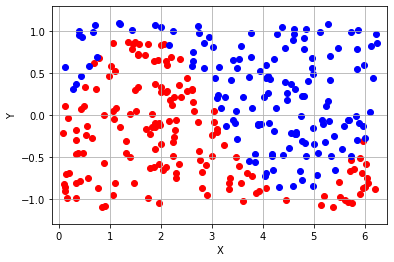

In [13]:
# Problem data:
np.random.seed(11)
n = 300
model = 'sine'
ymargin = 0.
noise = 0.0             # <========= Modifica este valor 0 ó 0.3, (antes responde a las cuestiones de arriba)
x1, x2, ytrain, xbnd, ybnd = utils.createDataSet(n, model, ymargin, noise, True)
x1test, x2test, ytest = utils.createDataSet(n*10, model, ymargin, noise)
Xtrain = np.concatenate((x1, x2), axis = 1)
Xtest = np.concatenate((x1test, x2test), axis = 1)
ytrain[ytrain == 0] = -1
ytest[ytest == 0] = -1
utils.plotData(x1,x2,ytrain,{'c':'#FF0000'},{'c':'#0000FF'})

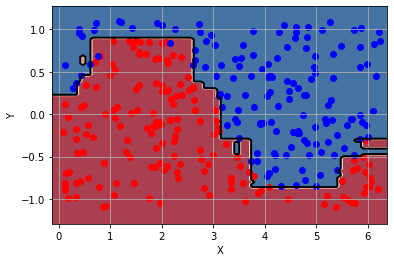

In [14]:
gb_regressor = GradientBoostingClassifier()
gb_regressor.fit(Xtrain, ytrain)
utils.plotModel(x1 ,x2, ytrain, gb_regressor)

In [15]:
from sklearn.preprocessing import LabelBinarizer

# Magic
fP = 'datos/magic04.csv'
dfP = pd.read_csv(fP, sep=',')

X_tr, X_ts, y_tr, y_ts = train_test_split(dfP.values[:,:-1], dfP.values[:,-1], 
                                          test_size=0.8, random_state=1)
lb   = LabelBinarizer(pos_label = 1, neg_label = -1)
y_tr = lb.fit_transform(y_tr).ravel()
y_ts = lb.transform(y_ts).ravel()

gb = GradientBoostingClassifier()

gb.fit(X_tr, y_tr)
print("Accuracy in Magic04=", gb.score(y_ts, gb.predict(X_ts)))

Accuracy in Magic04= 0.8621188222923238


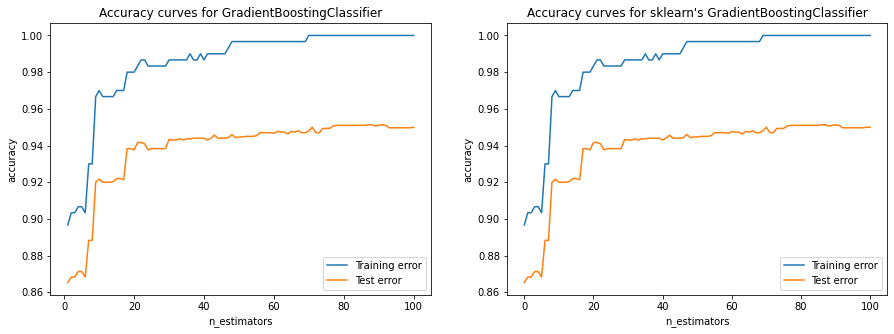

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

gb = GradientBoostingClassifier()
gb.fit(Xtrain, ytrain)
acc_train = [ gb.score(ytrain, gb.predict_with_fewer_estimators(Xtrain, n_est))
                for n_est in range(1, gb.n_estimators)]
acc_test = [ gb.score(ytest, gb.predict_with_fewer_estimators(Xtest, n_est))
                for n_est in range(1, gb.n_estimators)]
xs = np.arange(1, gb.n_estimators)
axs[0].plot(xs, acc_train, label = "Training error")
axs[0].plot(xs, acc_test, label = "Test error")
axs[0].legend()
axs[0].set_title("Accuracy curves for GradientBoostingClassifier")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("accuracy")

gb_sklearn = GBClassifier_Sklearn(n_estimators=101)
gb_sklearn.fit(Xtrain, ytrain)
acc_train_sk = [np.mean(predictions == ytrain) for predictions in gb_sklearn.staged_predict(Xtrain)]
acc_test_sk = [np.mean(predictions == ytest) for predictions in gb_sklearn.staged_predict(Xtest)]
xs = np.arange(gb.n_estimators)
axs[1].plot(xs, acc_train_sk, label = "Training error")
axs[1].plot(xs, acc_test_sk, label = "Test error")
axs[1].legend()
axs[1].set_title("Accuracy curves for sklearn's GradientBoostingClassifier")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("accuracy")

plt.show()

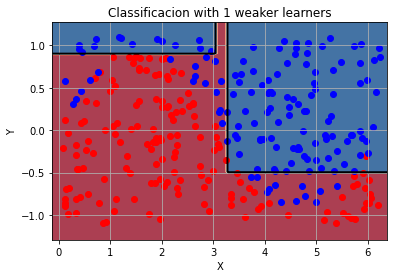

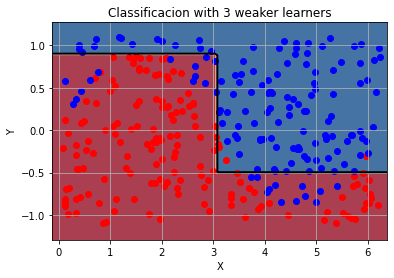

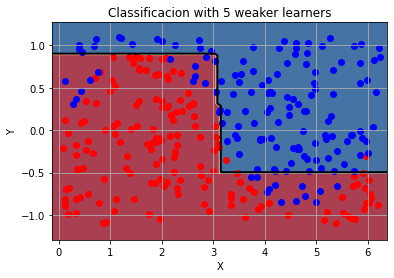

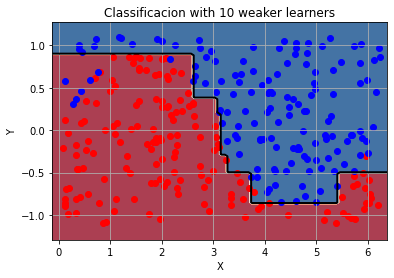

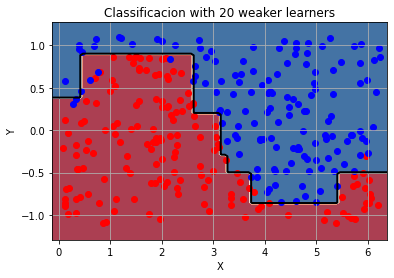

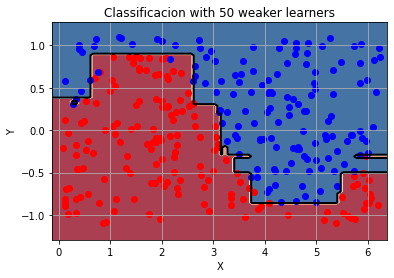

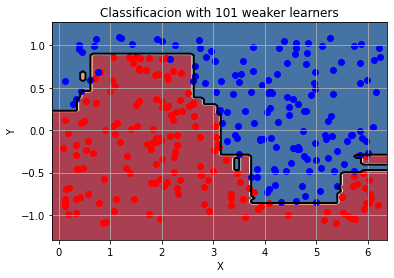

In [17]:
gb = GradientBoostingClassifier()
gb.fit(Xtrain, ytrain)
for n_estimators in [1, 3, 5, 10, 20, 50, 101]:
    utils.plotModel(x1, x2, ytrain, gb,
              title='Classificacion with {} weaker learners'.format(n_estimators),
              fewer_estimators=n_estimators)
    plt.show()

## Regresión

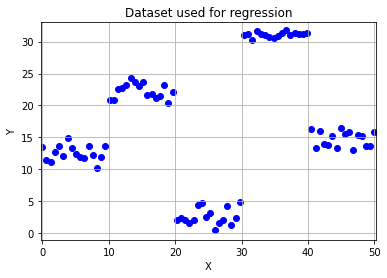

In [18]:
# Problem data for regression:
np.random.seed(123)
n = 100
Xtrain_reg, ytrain_reg, Xtest_reg, ytest_reg = utils.createRegressionDataSet(n)
utils.plotRegressionData(Xtrain_reg, ytrain_reg, 'Dataset used for regression')

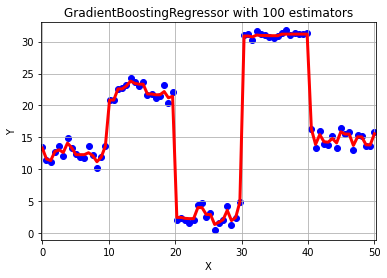

In [19]:
gb = GradientBoostingRegressor()
gb.fit(Xtrain_reg, ytrain_reg)
utils.plotRegressionModel(Xtrain_reg, ytrain_reg, gb, "GradientBoostingRegressor with 100 estimators")

In [20]:
gb = GradientBoostingRegressor()
gb.fit(Xtrain_reg, ytrain_reg)
print('Score (MSE) in training: {}'.format(gb.score(ytrain_reg, gb.predict(Xtrain_reg))))
print('Score (MSE) in test: {}'.format(gb.score(ytest_reg, gb.predict(Xtest_reg))))

Score (MSE) in training: 0.18254289509594124
Score (MSE) in test: 2.076363303282817


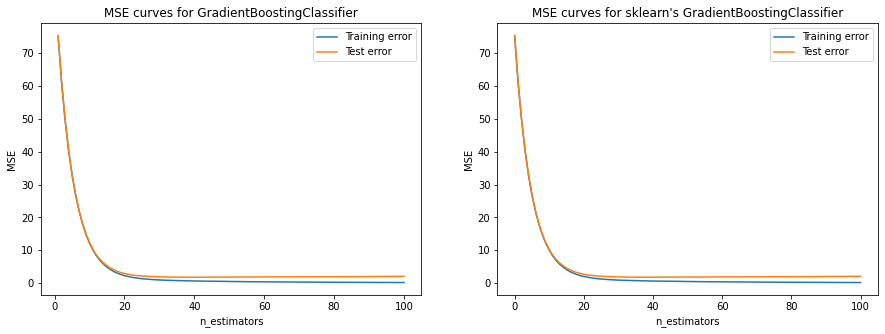

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

gb = GradientBoostingRegressor()
gb.fit(Xtrain_reg, ytrain_reg)
acc_train = [ gb.score(ytrain_reg, gb.predict_with_fewer_estimators(Xtrain_reg, n_est))
                for n_est in range(1, gb.n_estimators)]
acc_test = [ gb.score(ytest_reg, gb.predict_with_fewer_estimators(Xtest_reg, n_est))
                for n_est in range(1, gb.n_estimators)]
xs = np.arange(1, gb.n_estimators)
axs[0].plot(xs, acc_train, label = "Training error")
axs[0].plot(xs, acc_test, label = "Test error")
axs[0].legend()
axs[0].set_title("MSE curves for GradientBoostingClassifier")
axs[0].set_xlabel("n_estimators")
axs[0].set_ylabel("MSE")

gb_sklearn = GBRegressor_Sklearn(n_estimators=101)
ytrain_shaped, ytest_shaped = np.ravel(ytrain_reg), np.ravel(ytest_reg)

gb_sklearn.fit(Xtrain_reg, ytrain_shaped)
acc_train_sk = [np.mean((ytrain_shaped - predictions) ** 2)
                for predictions in gb_sklearn.staged_predict(Xtrain_reg)]
acc_test_sk = [np.mean((ytest_shaped - predictions) ** 2)
               for predictions in gb_sklearn.staged_predict(Xtest_reg)]
xs = np.arange(gb.n_estimators)
axs[1].plot(xs, acc_train_sk, label = "Training error")
axs[1].plot(xs, acc_test_sk, label = "Test error")
axs[1].legend()
axs[1].set_title("MSE curves for sklearn's GradientBoostingClassifier")
axs[1].set_xlabel("n_estimators")
axs[1].set_ylabel("MSE")

plt.show()

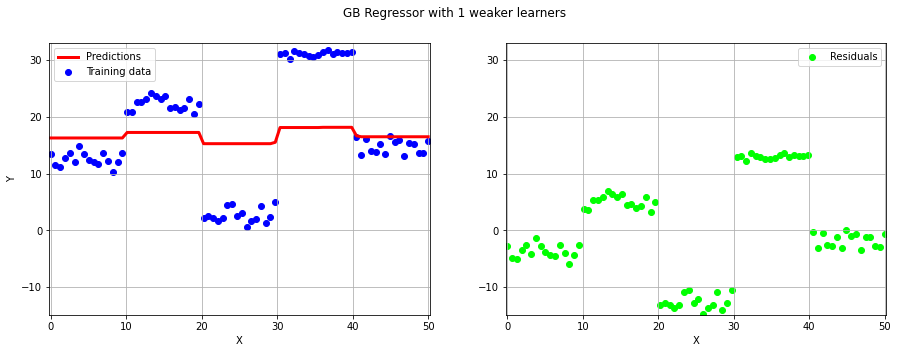

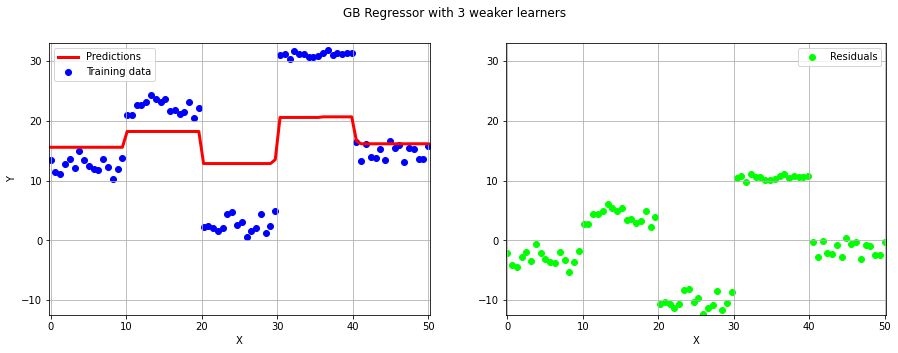

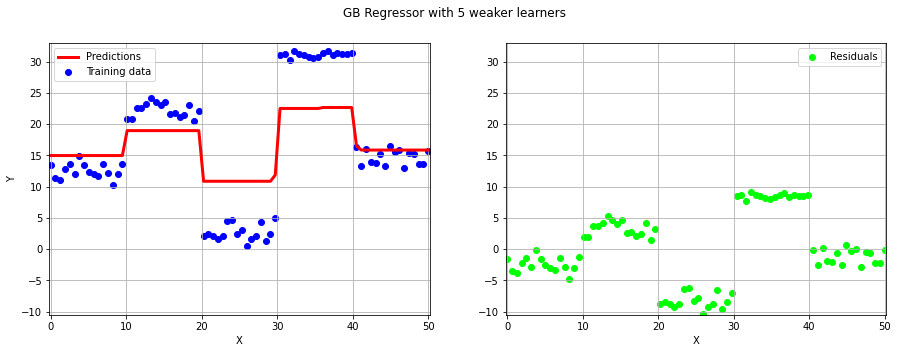

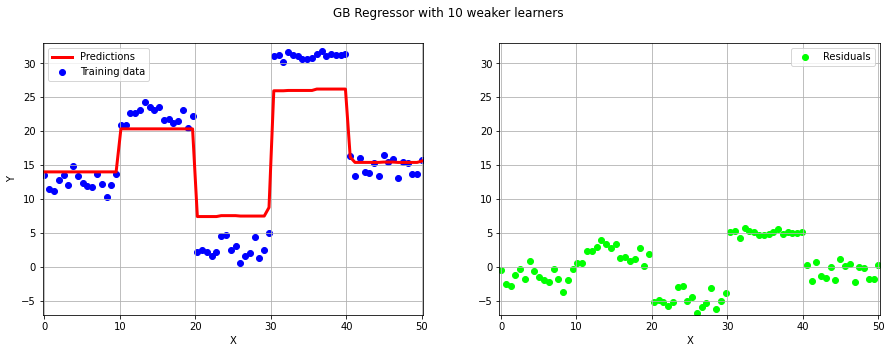

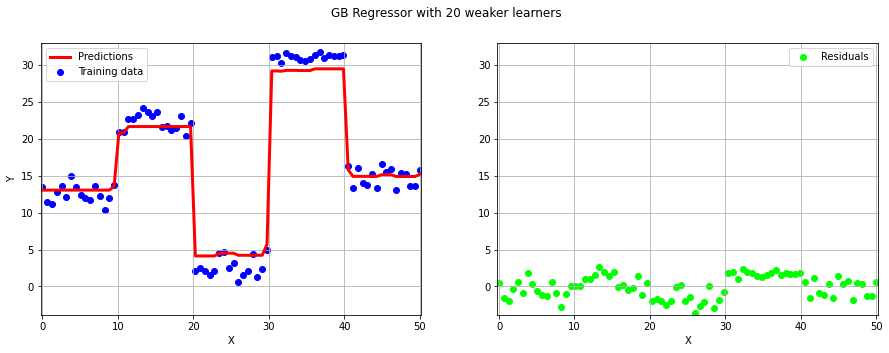

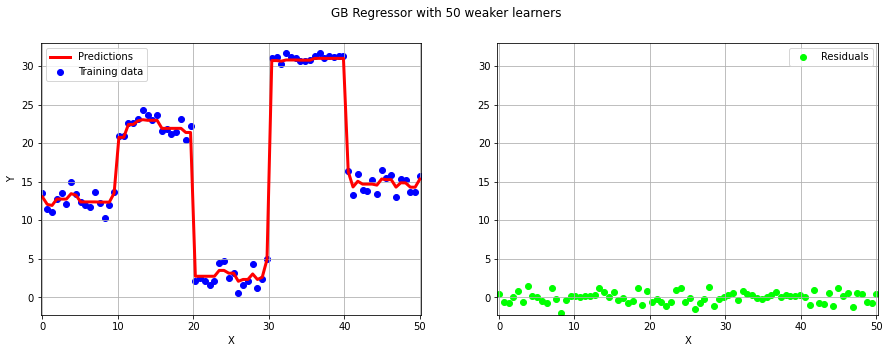

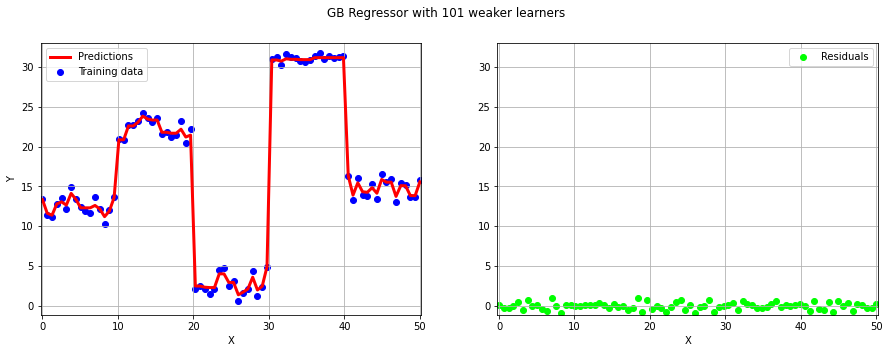

In [22]:
for n_estimators in [1, 3, 5, 10, 20, 50, 101]:
    gb = GradientBoostingRegressor(n_estimators=n_estimators)
    gb.fit(Xtrain_reg, ytrain_reg)
    utils.plotRegressionModelWithResiduals(Xtrain_reg, ytrain_reg, gb,
              title='GB Regressor with {} weaker learners'.format(n_estimators))
    plt.show()